In [32]:
import tensorflow as tf
import random
from tensorflow.keras import datasets, layers, models
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tranco import Tranco
from datetime import date, datetime, timedelta
from tqdm import tqdm
import random

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [33]:
####################### Prepare Dataset #######################
dga = list()
with open("dga.txt", "r") as f:
    content = f.readlines()
    dga = list(set([ l.split()[1] for l in content if not l.startswith("#") and len(l.split()) == 6]))
print(len(dga), dga[:30])

1204152 ['qaworasildeafeninguvuc.com', 'jqtyohvoixtrasyn.eu', 'pdrog6yvjulggbm3k6.net', 'bkotvioifrupchra.eu', 'yevysagabardinedazyx.com', 'q3uh2v1upwhalev7p4.biz', 'paikkrajnyhhqvom.eu', 'dpmcfordlinnetavox.com', 'isqqlodsholapet.com', 'vtdhdxlltctmxmeo.eu', 'sukuellefrictionlessv.com', 'egerasddrxm.sh', 'yokdxuoecrrssaak.eu', 'npxqidablyhoosieraw.com', 'akitomqtqdlyrjva.eu', 'nwmximsfyyfsbofc.eu', 'dbltdjufjpgpmrmy.eu', 'gqddleasuredehydratorysagp.com', 'lmqgx57j7co2rf48f8.ru', 'twcwgmnfprhgxsjr.eu', 'shsfanvqwyrmnlcj.eu', 'wtqbukmlsnavohxp.eu', 'liijdejqvfflhrmo.eu', 'kijntipodaobhcxk.eu', 'vywheerqwvog.ru', 'crr5qjjijseukykx2z.com', 'gcuwlktrdytcapkh.eu', 'rvtsfordlinnetavox.com', 'tzrtbyplaywobb.com', 'jsedajfjaqrbqapv.eu']


In [34]:
t = Tranco(cache=True, cache_dir='.tranco')

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = datetime(2020, 4, 20)
end_date = datetime(2020, 6, 20) + timedelta(days = 1)

occurence_counter = dict()

for single_date in tqdm(list(daterange(start_date, end_date))):
    tranco_1M = set(t.list(date=single_date.strftime("%Y-%m-%d")).top(1000000))
    for d in tranco_1M:
        if d not in occurence_counter:
            occurence_counter[d] = 0
        occurence_counter[d] += 1
benign = [ k for k, v in occurence_counter.items() if v >= 30 ]
benign = list(set(benign) - set(dga))
print(len(benign), benign[:30])

100%|██████████| 62/62 [01:45<00:00,  1.69s/it]


992897 ['bobaemhc.com', 'csteelnews.com', 'voapartners.com', 'u1sf.com', 'interfisio.com.br', 'mtballoons.com', 'practicalmotoring.com.au', 'mountainview.gov', 'mairie-le-verger.fr', 'mbtshoesonline.com', 'cbdmerchantservices.net', 'cloudexpoeurope.com', 'jard.pl', 'argusdevelopment.net', 'webatu.com', 'certima.cz', 'suntimesnews.com', 'revistafusion.com', 'batikpoker.top', 'rehobothexo.com', 'tandbergdata.com', 'iradionet.com.br', 'monkeyland.us', 'flagsonthecheap.com', 'bgpintl.com', 'extendedstayamerica.com', 'hseni.gov.uk', 'nyirprotect.hu', 'penleyinc.com', 'aclass.com.sg']


In [38]:
X = np.array(dga + benign)
Y = np.array([1] * len(dga) + [0] * len(benign))

valid_chars = {x:idx+1 for idx, x in enumerate(set(''.join(X)))}
max_features = len(valid_chars) + 1
max_len = max([len(i) for i in dga + benign])

X = [[valid_chars[y] for y in x] for x in X]
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_len)

print(X[0])

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

print(len(x_train), len(x_test))
print(valid_chars, max_len, max_features)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 33 38 22 35 28 38 13
 10 23 19  2 38  1  2  8 10  8 30 20 21 20 26 16 26 35 25]
1757639 439410
{'f': 1, 'e': 2, 'j': 3, '-': 4, '5': 5, 'k': 6, 'y': 7, 'n': 8, '9': 9, 'i': 10, '8': 11, '3': 12, 's': 13, '1': 14, 'z': 15, '.': 16, 't': 17, '4': 18, 'd': 19, 'u': 20, 'v': 21, 'w': 22, 'l': 23, 'x': 24, 'm': 25, 'c': 26, '0': 27, 'r': 28, '6': 29, 'g': 30, '2': 31, 'h': 32, 'q': 33, 'b': 34, 'o': 35, '7': 36, 'p': 37, 'a': 38} 67 39


In [39]:
domain_input = tf.keras.Input(shape = (max_len,), name='text_input')
input_layer = layers.Embedding(max_features, 128, input_length=max_len)(domain_input)
lstm = layers.LSTM(128)(input_layer)
lstm = layers.Dropout(0.5)(lstm)
lstm = layers.Dense(1)(lstm)
block_1_output = layers.Activation('sigmoid')(lstm)

conv_a = layers.Conv1D(15,2, activation='relu')(input_layer)
conv_b = layers.Conv1D(15,4, activation='relu')(input_layer)
conv_c = layers.Conv1D(15,6, activation='relu')(input_layer)
pool_a = layers.GlobalMaxPooling1D()(conv_a)
pool_b = layers.GlobalMaxPooling1D()(conv_b)
pool_c = layers.GlobalMaxPooling1D()(conv_c)
flattened = layers.add([pool_a, pool_b, pool_c])
drop = layers.Dropout(0.5)(flattened)
dense = layers.Dense(1)(drop)
block_2_output = layers.Activation("sigmoid")(dense)

output = layers.add([block_1_output, block_2_output])

model = tf.keras.Model(domain_input, output)
model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 67)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 67, 128)      4992        text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 66, 15)       3855        embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 64, 15)       7695        embedding_3[0][0]                
____________________________________________________________________________________________

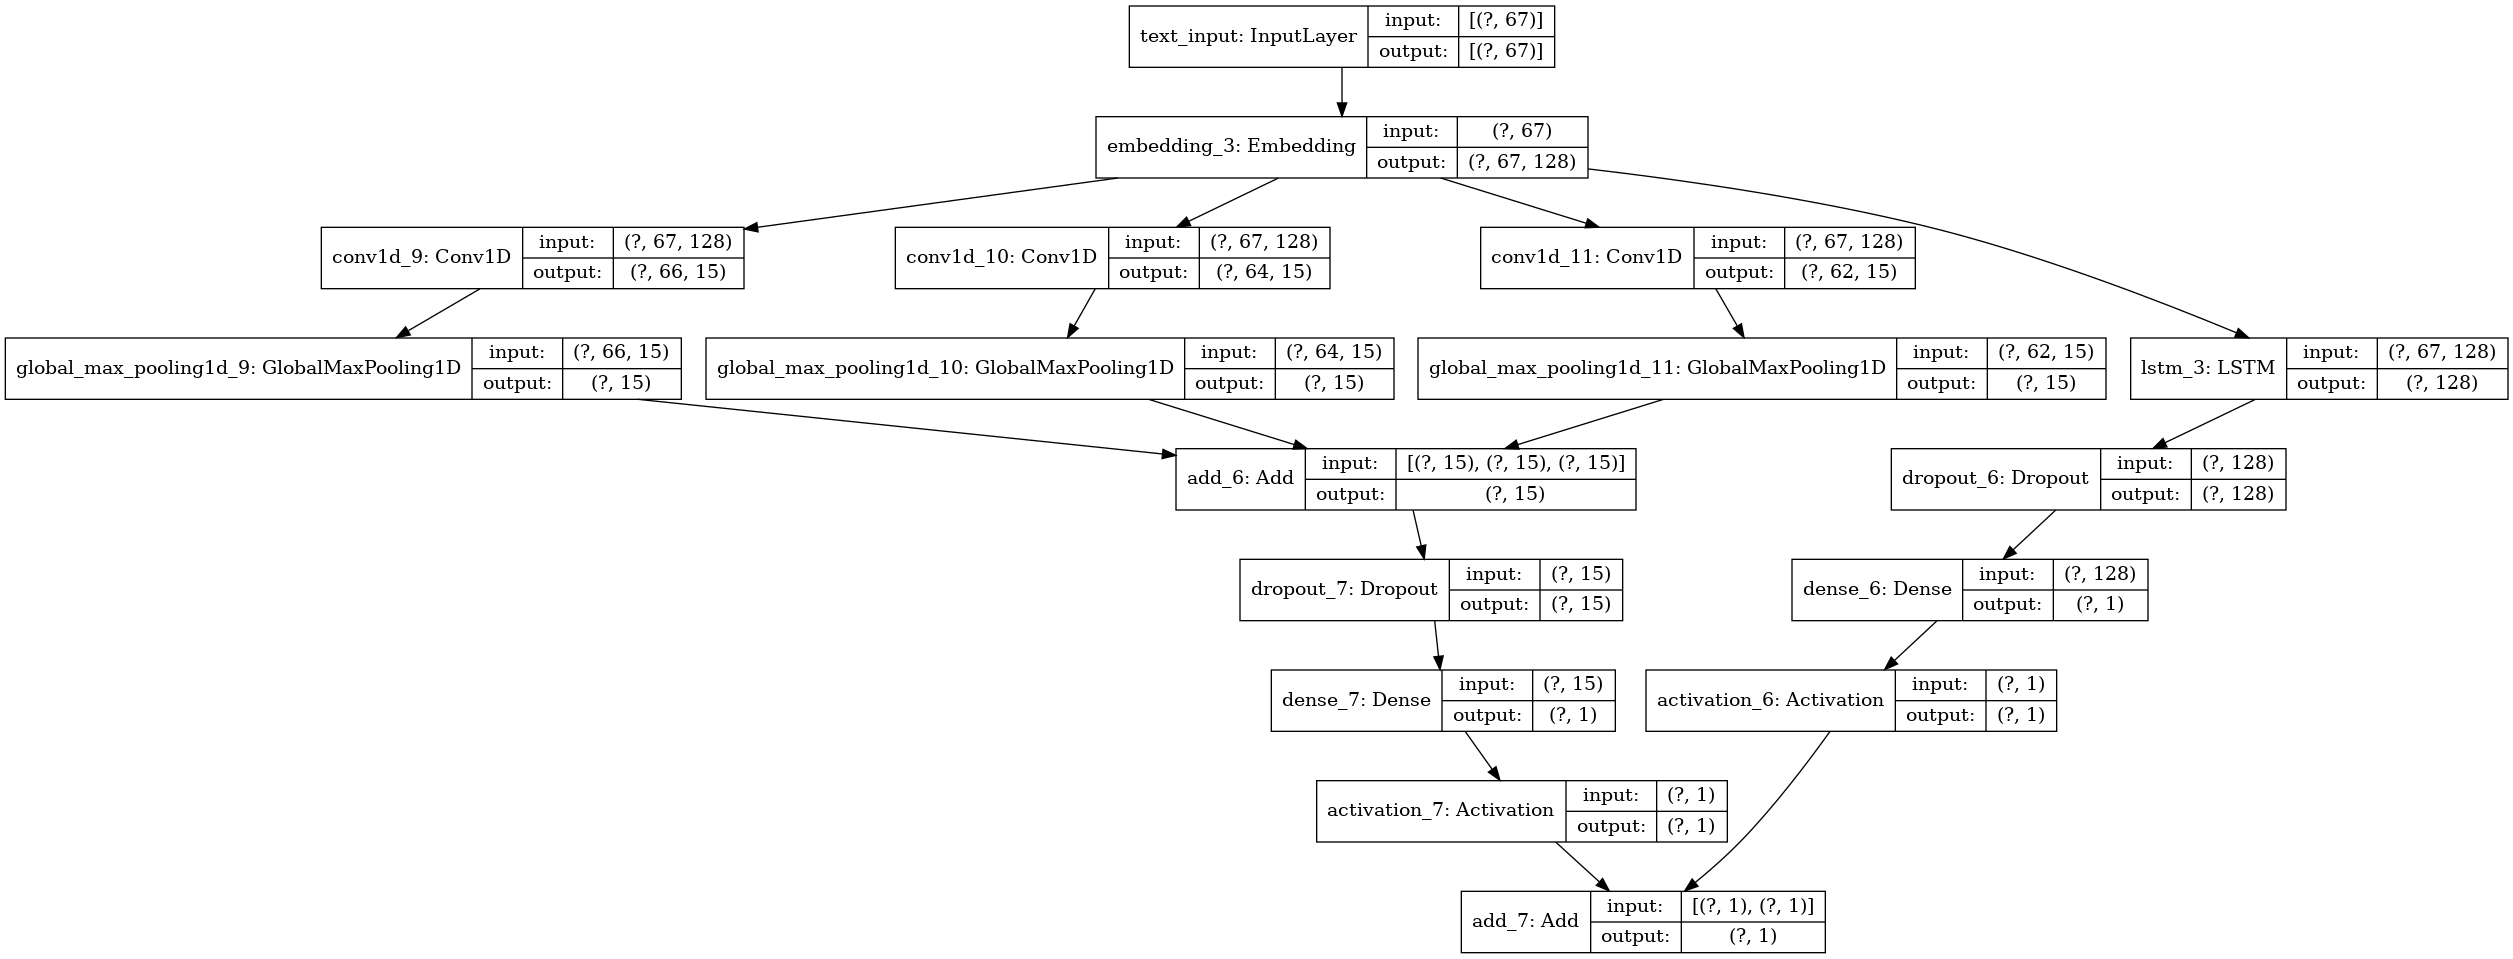

In [40]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [41]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_split=0.1, callbacks=[earlyStopping])

Train on 1581875 samples, validate on 175764 samples
Epoch 1/100
1581875/1581875 [==============================] - 314s 199us/sample - loss: 0.0642 - accuracy: 0.9792 - val_loss: 0.0286 - val_accuracy: 0.9906
Epoch 2/100
1581875/1581875 [==============================] - 312s 197us/sample - loss: 0.0262 - accuracy: 0.9917 - val_loss: 0.0220 - val_accuracy: 0.9927
Epoch 3/100
1581875/1581875 [==============================] - 312s 197us/sample - loss: 0.0226 - accuracy: 0.9929 - val_loss: 0.0199 - val_accuracy: 0.9936
Epoch 4/100
1581875/1581875 [==============================] - 312s 197us/sample - loss: 0.0210 - accuracy: 0.9935 - val_loss: 0.0193 - val_accuracy: 0.9938
Epoch 5/100
1581875/1581875 [==============================] - 311s 197us/sample - loss: 0.0202 - accuracy: 0.9938 - val_loss: 0.0221 - val_accuracy: 0.9929
Epoch 6/100
1581875/1581875 [==============================] - 312s 197us/sample - loss: 0.0196 - accuracy: 0.9941 - val_loss: 0.0197 - val_accuracy: 0.9942
Epoch

Text(0, 0.5, 'accuracy')

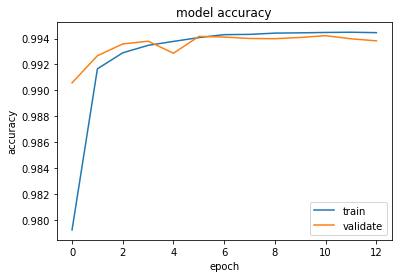

In [42]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validate'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [43]:
y_test_pred = model.predict(x_test)

In [44]:
sklearn.metrics.confusion_matrix(y_test, y_test_pred > .5)

array([[197618,    796],
       [  2021, 238975]])

In [45]:
print(sklearn.metrics.classification_report(y_test, y_test_pred > .5))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    198414
           1       1.00      0.99      0.99    240996

    accuracy                           0.99    439410
   macro avg       0.99      0.99      0.99    439410
weighted avg       0.99      0.99      0.99    439410



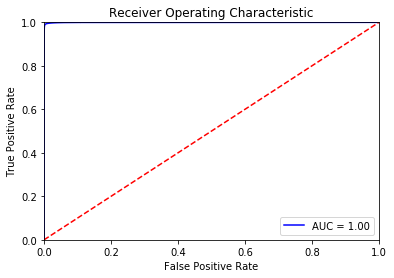

In [46]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, y_test_pred)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()